## 개념과 구조
``상태관리 능력``

각 서브 그래프는 자신만의 고유한 상태 정의 및 관리 가능하며 부모그래프와 공유할 수 있음 </br>
상태관리는 체크포인터를 통해 이루어지며, 실행중인 상태를 저장하고 복원할 수 있어서 복잡한 워크플로우 구현 가능

* LnagGraph에서 복잡한 시스템을 관리 가능한 모듈화 할 수 있는 개념
* 더 큰 그래프 내에서 독립적으로 실행되는 작은 단위의 그래프
* 자체적인 상태,노드,엣지를 가질 수 있음
* 부모그래프와 상태를 공유하거나 독립할 수 있어서, 시스템 설계의 유연성 향상

## 설계 원칙

`단일 책임 원칙`
`알관성 유지`

* 각 서브그래프는 `명확한 하나의 책임을 가져야함`
* `서브 그래프 간 의존성을 최소화`
* 명확한 인터페이스를 정의하며 `느슨한 결합`
* 순환 참조를 피하고, `적절한 상태 범위` 설정
* 명확한 `에러 처리 로직` 구현
* `적절한 깊이 제한` , `불필요한 상태 공유 최소화`

## 서브 그래프 구조화

* 메인 그래프는 전체 워크 플로우를 조율함
* 서브 그래프는 특정 작업을 독립적으로 처리함 

### 서브 그래프 구현
`상태 정의` -> `노드 함수 구현` -> `그래프 구성`
* 구현 단계는 일반 그래프의 구현 순서와 동일함
* 부모(메인)그래프와 통합함으로써 구조화 할 수 있음

In [1]:
from configs import llm

In [2]:
# 상태 정의
from typing import TypedDict
from typing import Annotated
from typing import List
import operator

from langchain_core.messages import AnyMessage,HumanMessage,AIMessage

class SubGaraphState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add] # 메시지 히스토리
    context: str # 컨텍스트 정보


In [3]:
# 노드 함수 구현

def process_node(state: SubGaraphState):
    current_message = state['messages'][-1]
    
    processed_result = f"Processed: {current_message.content}"
    return {"context": processed_result}

def respond_node(state:SubGaraphState):
    context = state['context']
    response = AIMessage(content=f"Response based on {context}")
    return {"messages": [response]}

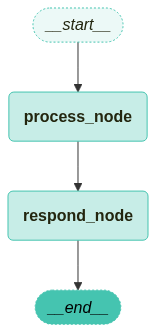

In [4]:
from langgraph.graph.state import StateGraph
from langgraph.graph.state import START
from langgraph.graph.state import END
from langchain_teddynote.graphs import visualize_graph
# 그래프 초기화
subgraph_builder = StateGraph(SubGaraphState)

# 노드 추가
subgraph_builder.add_node("process_node",process_node)
subgraph_builder.add_node("respond_node",respond_node)

# 엣지 추가
subgraph_builder.add_edge(START,"process_node")
subgraph_builder.add_edge("process_node","respond_node")
subgraph_builder.add_edge("respond_node",END)

# 그래프 컴파일
subgraph = subgraph_builder.compile()
visualize_graph(subgraph)

In [5]:
# 그래프 실행
init_config = SubGaraphState(
    {
    "context": "",
    "messages":[HumanMessage(content="hello world!")]
    }
)

result = subgraph.invoke(init_config)

# 결과 확인
for message in result['messages']:
    print(f"Message: {message.content}")

Message: hello world!
Message: Response based on Processed: hello world!


## 메인그래프에 통합

In [6]:
from typing import Literal
from typing import Optional
class MainState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add] # 메시지 히스토리
    context: str # 컨텍스트 정보
    subgraph_result: Optional[str]
    processing_status:str


In [7]:
# 메인 그래프의 노드 함수 구현

def preprocessing(state:MainState):
    return {
        "context": f"Context from {state['messages'][-1].content}",
        "processing_status": "preprocessing_complete"
    }

def postprocessing(state:MainState):
    context = state.get("context","")
    return {
        "subgraph_result": f"Final result based on context {context}",
        "processing_status": "complete"
    }

# 라우링 로직 구현

def route_next(state: MainState) -> Literal["postprocessing","reprocess"]:
    next_node = "postprocessing" if state['processing_status'] == "preprocessing_complete" else "reprocess"
    return next_node
    

In [10]:
# 메인 그래프 구성
main_graph = StateGraph(MainState)

# 노드 추가
main_graph.add_node("preprocessing", preprocessing)
main_graph.add_node("subgraph", subgraph_builder.compile())  # 기존 서브그래프
main_graph.add_node("postprocessing", postprocessing)

# 엣지 추가
main_graph.add_edge(START, "preprocessing")
main_graph.add_edge("preprocessing", "subgraph")
main_graph.add_conditional_edges(
    "subgraph", 
    route_next,
    {
        "postprocessing": "postprocessing",
        "reprocess": "preprocessing"
    }
)
main_graph.add_edge("postprocessing", END)
# 그래프 컴파일
compiled_maingraph = main_graph.compile()

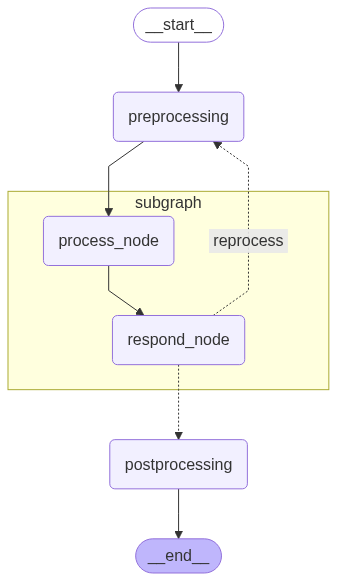

In [12]:
from IPython.display import Image

# 그래프 시각화
maingraph_image = compiled_maingraph.get_graph(xray=True).draw_mermaid_png()
display(Image(maingraph_image))


In [13]:
initial_state = {
   "messages": [HumanMessage(content="Hello!")],  
   "processing_status": "started"
}


In [14]:
try:
   result = compiled_maingraph.invoke(initial_state)
   print("실행 결과:")
   print(f"처리 상태: {result['processing_status']}")
   print(f"최종 결과: {result['subgraph_result']}")
except Exception as e:
   print(f"그래프 실행 실패: {e}")


실행 결과:
처리 상태: complete
최종 결과: Final result based on context Processed: Hello!
